# Scrape Berufslexikon

Scrape https://www.berufslexikon.at/berufe/ for all professions & href links and save them in a json file.

1 of error, but no problem, since all professions are scraped.

In [51]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import random
import time

# Initialize an empty dictionary
professions = {}

# Setup Firefox options
firefox_options = Options()
firefox_options.add_argument("--headless")  # Ensure GUI is off


# Choose Firefox Browser
driver = webdriver.Firefox(executable_path=r'C:\Tools\GeckoDriver\geckodriver.exe')

url = "https://www.berufslexikon.at/berufe/"
driver.get(url)

# Wait for the page to fully load
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "table")))

# Try to accept cookies
try:
    accept_cookies_button = driver.find_element_by_id('btCookieConsentButtonAllowAll')
    accept_cookies_button.click()
except NoSuchElementException:
    pass  # If the button is not found, just ignore

# Wait for the page to fully load
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "table")))

# Try to select 100 from the dropdown
try:
    select = Select(driver.find_element_by_name('list-table_length'))
    select.select_by_value('100')
except NoSuchElementException:
    print("Could not find dropdown or value 100")

# Loop through each page
for i in range(0, 18):  # 18 pages
    # Randomize wait time between requests
    ran = random.randint(1, 5)/100

    # Wait until the processing panel is not visible
    try:
        WebDriverWait(driver, 10).until(EC.invisibility_of_element_located((By.ID, "list-table_processing")))
    except TimeoutException:
        print("Timed out waiting for processing panel to disappear.")
        continue  # Skip this iteration and try the next page

    # Try to find the page button
    try:
        
        #page_btn = driver.find_element_by_css_selector(f'a[aria-controls="list-table"][data-dt-idx="{i}"]')
        #<a href="#" aria-controls="list-table" data-dt-idx="8" tabindex="0">Vor</a>
        page_btn = driver.find_element_by_css_selector(f'a[aria-controls="list-table"][data-dt-idx="8"]')
    except Exception as e:
        print("did not find page button")
        break  # If we can't find it, we're on the last page

    # # Scroll the page button into view
    # driver.execute_script("arguments[0].scrollIntoView();", page_btn)

    # Scroll to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    time.sleep(ran)

    # Click the page button and wait for the page to load
    page_btn.click()
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "table")))

    # Parse the page
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    rows = soup.findAll('table')[0].findAll('tr')
    for row in rows:
        links = row.select('a[href^="/berufe"]')
        for link in links:
            print(link['href'], link.text)
            # Store in format {name: link}
            professions[link.text] = link['href']

driver.quit()

/berufe/3045-24-Stunden-BetreuerIn/ 24-Stunden-BetreuerIn
/berufe/3049-3D-DesignerIn/ 3D-DesignerIn
/berufe/3866-AbfallbeauftragteR/ AbfallbeauftragteR
/berufe/3200-AbfallberaterIn/ AbfallberaterIn
/berufe/2147-AbfallwirtschaftstechnikerIn/ AbfallwirtschaftstechnikerIn
/berufe/3696-AbnahmetechnikerIn/ AbnahmetechnikerIn
/berufe/3818-Entsorgungsfachkraft_fuer_Abwassertechnik/ AbwassertechnikerIn
/berufe/2814-Aerobic-TrainerIn/ Aerobic-TrainerIn
/berufe/2963-AfrikanistIn/ AfrikanistIn
/berufe/1934-AgrarberaterIn/ AgrarberaterIn
/berufe/2987-Agrarbiologe~Agrarbiologin/ Agrarbiologe/-biologin
/berufe/1935-Agrarkaufmann~Agrarkauffrau/ Agrarkaufmann/Agrarkauffrau
/berufe/3835-AgrarmanagerIn/ AgrarmanagerIn
/berufe/2593-AgraroekonomIn/ AgrarökonomIn
/berufe/2297-Aegyptologe~Aegyptologin/ Ägyptologe/Ägyptologin
/berufe/2468-AktuarIn/ AktuarIn
/berufe/3050-AkustikerIn/ AkustikerIn
/berufe/3051-AkustikphysikerIn/ AkustikphysikerIn
/berufe/2298-AltsemitischeR-Philologe~Philologin-Orientalistische

ElementNotInteractableException: Message: Element <a href="#"> could not be scrolled into view


Save to File

In [11]:
import os
import csv

# Check if file exists
if not os.path.exists('data/professions.csv'):
    # If file does not exist, write to file
    with open('professions.csv', 'w', newline='') as f:
        writer = csv.writer(f, delimiter=';')
        for key in professions.keys():
            writer.writerow([key, professions[key]])
else:
    # If file exists, retrieve from file
    with open('data/professions.csv', 'r') as f:
        reader = csv.reader(f, delimiter=';')
        professions = {rows[0]:rows[1] for rows in reader}

# Scrape Individual Profession

working

In [66]:
import requests
from bs4 import BeautifulSoup
import json
import random
import time
import os


# Check if file exists
if os.path.exists('data/berufslexikon.json'):
    # If file exists, read existing data
    with open('data/berufslexikon.json', 'r', encoding='utf-8') as f:
        existing_data = json.load(f)
        last_profession = existing_data[-1]['profession'] if existing_data else None
else:
    last_profession = None

start = False if last_profession else True

for key, value in professions.items():
    if not start and key == last_profession:
        start = True
        continue

    if not start:
        continue

    url = "https://www.berufslexikon.at" + value
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the page content
    page_content = soup.find(id='pageContent')

    # Prepare data for JSON
    data = {
        "profession": key,
        "url": url,
        "content": page_content.text if page_content else None
    }

    # If file does not exist or is empty, write data as the first item of a list
    if not os.path.isfile('data/berufslexikon.json') or os.stat('data/berufslexikon.json').st_size == 0:
        with open('data/berufslexikon.json', 'w', encoding='utf-8') as f:
            json.dump([data], f, ensure_ascii=False, indent=4)
    else:
        # If file exists and is not empty, append data to the list
        with open('data/berufslexikon.json', 'r+', encoding='utf-8') as f:
            existing_data = json.load(f)
            existing_data.append(data)
            f.seek(0)  # reset file position to the beginning
            json.dump(existing_data, f, ensure_ascii=False, indent=4)

    # wait for random time
    #ran = random.randint(1, 5)/1000
    #time.sleep(ran)
    print(key, value)
print("done")

MusikerIn /berufe/2938-MusikerIn/
MusikerIn - Elektroakustische Musik /berufe/2376-MusikerIn-Elektroakustische-Musik/
MusikinstrumentenerzeugerIn /berufe/1892-MusikinstrumentenerzeugerIn/
Musikpädagoge/Musikpädagogin /berufe/2368-Musikpaedagoge~Musikpaedagogin/
MusiktherapeutIn /berufe/2371-MusiktherapeutIn/
MusikwissenschafterIn /berufe/2236-MusikwissenschafterIn/
NachhaltigkeitsbeauftragteR /berufe/3822-NachhaltigkeitsbeauftragteR/
NachhaltigkeitsmanagerIn /berufe/3861-NachhaltigkeitsmanagerIn/
NachmittagsbetreuerIn /berufe/3235-NachmittagsbetreuerIn/
NachrichtentechnikerIn /berufe/3286-NachrichtentechnikerIn/
NachrichtentechnikerIn für Funktechnik /berufe/1909-NachrichtentechnikerInfrFunktechnik/
Nah- und DistributionslogistikerIn /berufe/3511-Nah-_und_DistributionslogistikerIn/
NäherIn /berufe/3708-NaeherIn/
NanotechnikerIn /berufe/2680-NanotechnikerIn/
NationalparkrangerIn /berufe/3236-NationalparkrangerIn/
NaturraummanagerIn /berufe/2988-NaturraummanagerIn/
NederlandistIn /berufe

# Statistics and Outlier

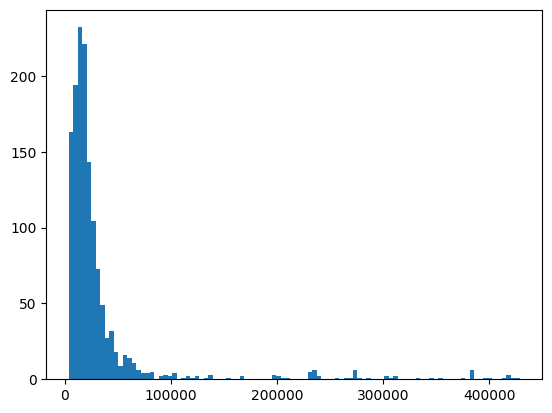

In [8]:
# plot length of content
import matplotlib.pyplot as plt
import numpy as np

with open('data/berufslexikon.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# get the lengths of the content
lengths = [len(entry['content']) for entry in data]

# plot the lengths
plt.hist(lengths, bins=100)
plt.show()

In [9]:
# make a dataframe, sort by length of content and print the first 25 entries
import pandas as pd
df = pd.DataFrame(data)
# count the number of characters in the content
df['content_length'] = df['content'].str.len()
# sort by content_length
df = df.sort_values(by=['content_length'], ascending=False)
# print the first 25 entries
df

,profession,url,content,content_length
84,Bankkaufmann/-frau,https://www.berufslexikon.at/berufe/1650-Bankk...,\n\n\n\n\n\n\nStart | Bankkaufmann/-frau\n\n\n...,428315
1121,SachbearbeiterIn,https://www.berufslexikon.at/berufe/1697-Sachb...,\n\n\n\n\n\n\nStart | SachbearbeiterIn\n\n\n\n...,421514
80,BankangestellteR - Back-Office,https://www.berufslexikon.at/berufe/1649-Banka...,\n\n\n\n\n\n\nStart | BankangestellteR - Back-...,419602
1275,TeamassistentIn,https://www.berufslexikon.at/berufe/1698-Teama...,\n\n\n\n\n\n\nStart | TeamassistentIn\n\n\n\n ...,417379
825,KundenbetreuerIn,https://www.berufslexikon.at/berufe/1693-Kunde...,\n\n\n\n\n\n\nStart | KundenbetreuerIn\n\n\n\n...,416867
...,...,...,...,...
596,GolflehrerIn,https://www.berufslexikon.at/berufe/2819-Golfl...,\n\n\n\n\n\n\nStart | GolflehrerIn\n\n\n\n Zur...,4344
1101,ReitlehrerIn,https://www.berufslexikon.at/berufe/2822-Reitl...,\n\n\n\n\n\n\nStart | ReitlehrerIn\n\n\n\n Zur...,4251
1182,Souffleur/Souffleuse,https://www.berufslexikon.at/berufe/3246-Souff...,\n\n\n\n\n\n\nStart | Souffleur/Souffleuse\n\n...,4082
1227,StatistIn,https://www.berufslexikon.at/berufe/2858-Stati...,\n\n\n\n\n\n\nStart | StatistIn\n\n\n\n Zurück...,4052


In [ ]:
import json
import re


def clean_content(content):

    content = re.sub('\n+', '\n', content)  # reduce multiple \n to one and replace with space
    # content = content.replace('\r', ' ')  # replace \r with space
    # content = content.replace('\t', ' ')  # replace \t with space
    content = re.sub(' +', ' ', content) #replace multiple spaces with one line break
    content = re.sub('\n ', '\n', content) #remove space after line break
    content = re.sub('\n+', '\n', content)  # reduce multiple \n to one and replace with space


    return content.strip()

def clean_data(data):
    cleaned_data = []
    for entry in data:
        cleaned_entry = {
            "profession": entry["profession"].strip(),
            "url": entry["url"].strip(),
            "content": clean_content(entry["content"])
        }
        cleaned_data.append(cleaned_entry)
    return cleaned_data
    

In [13]:
import json
import re

# Load the JSON file
with open('data/berufslexikon.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Define the regex patterns
pattern1 = re.compile(
    r'\nErgebnisse aus dem Ausbildungskompass:\n.*?(?=\nWeiterbildung\n|\nAufstieg und Selbstständigkeit\n|$)',
    re.DOTALL
)
pattern2 = re.compile(r"\n\n\n\n\nWeiterführende Informationen\n\n.*", re.DOTALL)
pattern3 = re.compile(r'\nAktuelles Update zu Berufsaussichten: Green Jobs\n.*?\nAusbildung\n', re.DOTALL)
pattern4 = re.compile(r'\nBeruf merken\n.*?\nTätigkeitsmerkmale\n', re.DOTALL)

# Iterate over each item and update the 'content' field using all patterns
for item in data:
    item['content'] = item['content'].replace("Start | ", "")
    item['content'] = re.sub(pattern1, '', item['content'])
    item['content'] = re.sub(pattern2, '', item['content'])
    item['content'] = re.sub(pattern3, '', item['content'])
    item['content'] = re.sub(pattern4, '', item['content'])

# Save the updated data back to the JSON file
with open('data/berufslexikon_regex.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)


In [14]:
# Clean the data
cleaned_data = clean_data(data)

# write to file and actually make a line break out of \n
with open('data/berufslexikon_regex_cleaned.json', 'w', encoding='utf-8') as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=4)

In [15]:
df = pd.DataFrame(data)
# count the number of characters in the content
df['content_length'] = df['content'].str.len()
# sort by content_length
df = df.sort_values(by=['content_length'], ascending=False)
# print the first 25 entries
df

,profession,url,content,content_length
207,Bürokaufmann/-frau,https://www.berufslexikon.at/berufe/25-Bueroka...,\n\n\n\n\n\n\nBürokaufmann/-frau\n\n\n\n Zurüc...,60783
680,Industriekaufmann/-frau,https://www.berufslexikon.at/berufe/97-Industr...,\n\n\n\n\n\n\nIndustriekaufmann/-frau\n\n\n\n ...,41744
1310,TiefbauspezialistIn - Schwerpunkt Tunnelbautec...,https://www.berufslexikon.at/berufe/3764-Tiefb...,\n\n\n\n\n\n\nTiefbauspezialistIn - Schwerpunk...,26465
364,ElektrotechnikerIn - Hauptmodul Anlagen- und B...,https://www.berufslexikon.at/berufe/3412-Elekt...,\n\n\n\n\n\n\nElektrotechnikerIn - Hauptmodul ...,26299
792,KonditorIn (ZuckerbäckerIn) - Schwerpunkt Pati...,https://www.berufslexikon.at/berufe/3633-Kondi...,\n\n\n\n\n\n\nKonditorIn (ZuckerbäckerIn) - Sc...,25744
...,...,...,...,...
1265,TankwartIn,https://www.berufslexikon.at/berufe/2812-Tankw...,\n\n\n\n\n\n\nTankwartIn\n\n\n\n Zurück\n\n\n\...,2060
541,GaragenwartIn,https://www.berufslexikon.at/berufe/3226-Garag...,\n\n\n\n\n\n\nGaragenwartIn\n\n\n\n Zurück\n\n...,2020
468,FensterputzerIn,https://www.berufslexikon.at/berufe/3222-Fenst...,\n\n\n\n\n\n\nFensterputzerIn\n\n\n\n Zurück\n...,1987
135,BeschließerIn,https://www.berufslexikon.at/berufe/2775-Besch...,\n\n\n\n\n\n\nBeschließerIn\n\n\n\n Zurück\n\n...,1957
